# Кейс-стади -2. 

Соревнования из kaggel: **Students Performance in Exams**: предсказание, насколько хорошо сдадут экзамены студенты. 
https://www.kaggle.com/spscientist/students-performance-in-exams

In [0]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import pearsonr
%matplotlib inline

Загружаем данные 

In [0]:
url='http://yustiks.ru/StudentsPerformance.csv'
s=requests.get(url).content
data=pd.read_csv(io.StringIO(s.decode('utf-8')))
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Можно увидеть, что результаты экаменов представлены в 3ех параметрах: это math score, reading score и writing score.

* gender - пол
* race/ethnicity - к какой расе принадлежит
* parental level of education - уровень образования родителей
* lunch - обед (какой тип)
* test preparation course - пройден или нет подготовительный курс
* math score - оценки по математике
* reading score - оценки за чтение
* writing score - оценки за письменность 

Посмотрим типы каждой колонки:

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
gender                         1000 non-null object
race/ethnicity                 1000 non-null object
parental level of education    1000 non-null object
lunch                          1000 non-null object
test preparation course        1000 non-null object
math score                     1000 non-null int64
reading score                  1000 non-null int64
writing score                  1000 non-null int64
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


Добавим новое значение на основе имеющихся: Total Score или общее количество набранных баллов за все предметы

In [0]:
data['total score'] = data['math score'] + data['reading score'] + data['writing score']

Посмотрим средние значения по результатам:

In [0]:
print("Average math score is    : {}".format(np.mean(data['math score'])))
print("Average reading score is : {}".format(np.mean(data['reading score'])))
print("Average writing score is : {}".format(np.mean(data['writing score'])))
print("Average total score is   : {}".format(np.mean(data['total score'])/3))

Average math score is    : 66.089
Average reading score is : 69.169
Average writing score is : 68.054
Average total score is   : 67.77066666666667


Посмотрим плотность распределения данных в таблице:

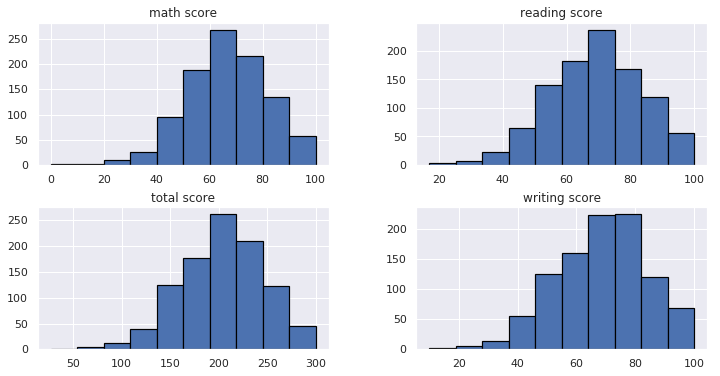

In [0]:
data.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()

В основном, у всех значений получилось нормальное Гауссово распределение. 

Используя библиотеку seaborn, начертим violinplot или скрипичная диаграмма. 

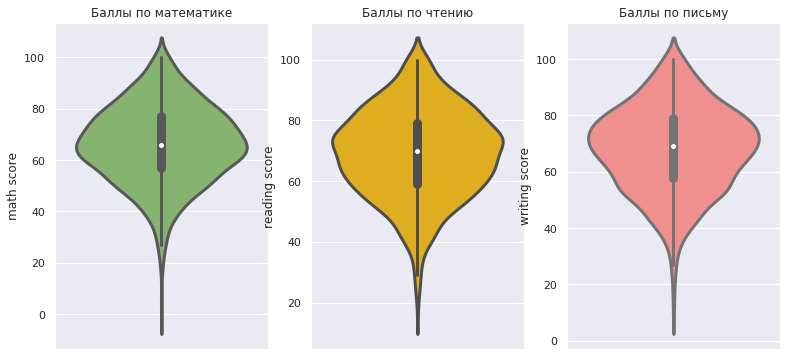

In [0]:
plt.figure(figsize=(13,6))
plt.subplot(1, 3, 1)
plt.title('Баллы по математике')
sns.violinplot(y='math score',data=data,palette='summer',linewidth=3)
plt.subplot(1, 3, 2)
plt.title('Баллы по чтению')
sns.violinplot(y='reading score',data=data,palette='Wistia_r',linewidth=3)
plt.subplot(1, 3, 3)
plt.title('Баллы по письму')
sns.violinplot(y='writing score',data=data,palette='spring',linewidth=3)
plt.show()

По графику можно увидеть, что значения по математике в основном находятся в интервале от 60 до 80, по чтению и письму от 50 до 80. 

Допустим, нам известно, проходные баллы по математике равны 40. Построим графики распределения тех, кто сдал и не сдал математику. 

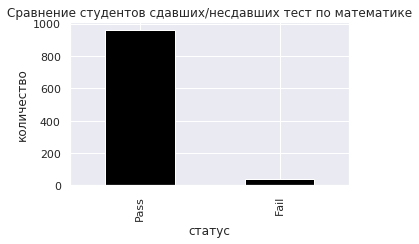

In [0]:
passmarks = 40

# создадим новую колонку
data['pass_math'] = np.where(data['math score']< passmarks, 'Fail', 'Pass')
data['pass_math'].value_counts(dropna = False).plot.bar(color = 'black', figsize = (5, 3))

plt.title('Сравнение студентов сдавших/несдавших тест по математике')
plt.xlabel('статус')
plt.ylabel('количество')
plt.show()

In [0]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score,pass_math
0,female,group B,bachelor's degree,standard,none,72,72,74,218,Pass
1,female,group C,some college,standard,completed,69,90,88,247,Pass
2,female,group B,master's degree,standard,none,90,95,93,278,Pass
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,Pass
4,male,group C,some college,standard,none,76,78,75,229,Pass


# Баесовский метод решения классификационной проблемы.

Лучшим другом аналитика данных является теорема Байеса4, которая позволяет "переставить" условные вероятности местами. Пусть нужно узнать вероятность не коего события E, зависящего от наступления некоего другого события F, причем в наличии имеется лишь информация о вероятности события F, зависящего от наступления события E. Двукратное применение (в силу симметрии) определения условной вероятности даст формулу Байеса:

$$ P(A\mid B) = \frac{P(B\mid A) P(A)}{P(B)}$$

где $P(A\mid B)$ - вероятность наступления события A при условии наличия события B

Если событие B разложить на два взаимоисключающих события B при условии A и B при условии $\bar{E}$, то событие P(B) можно представить как сумма вероятностей наступления событий $P(B\mid A)$ и  $P(B\mid \bar{A})$, тогда формула вероятности примет вид:

$$P(A\mid B) = \frac{P(B\mid A) P(A)}{P(B\mid A)P(A) + P(B\mid \bar{A})P(\bar{A})}$$

Если события независимы:

$$P(A\mid B) = P(A)P(B)$$

Если события зависимы, и при этом вероятность B не равна нулю, то 

$$P(A\mid B) = \frac{P(A, B) }{P(B)}$$

Под этим подразумевается вероятность наступления события A при условии, что известно о наступлении события B.

В случае независимости двух переменных формула принимает вид:

$$P(A\mid B) = P(A)$$

означает, что наличие наступления события B не дает нам никакой информации о наступлении события A

# Логистическая регрессия - математическая модель на основе баесовский теории о предсказании класса. 

Есть 2 класса - те, кто сдал математику, и те, кто не сдал математику. В исходном датасете количество студентов, сдавших экзамен, гораздо больше, чем тех, кто не сдал. Это называется несбалансированный датасет. 


*   Понижающая выборка
*   Повышающая выборка




График **bar plot**

[960, 40]


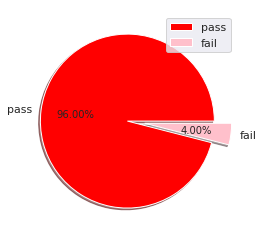

In [0]:

size = list(data['pass_math'].value_counts())
print(size)
colors = ['red', 'pink']
labels = "pass", "fail"
explode = [0, 0.2]

plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%', explode = explode, shadow = True)
plt.legend()
plt.show()

Посмотрим распределение тех, кто прошел **подготовительные курсы**, по полу.

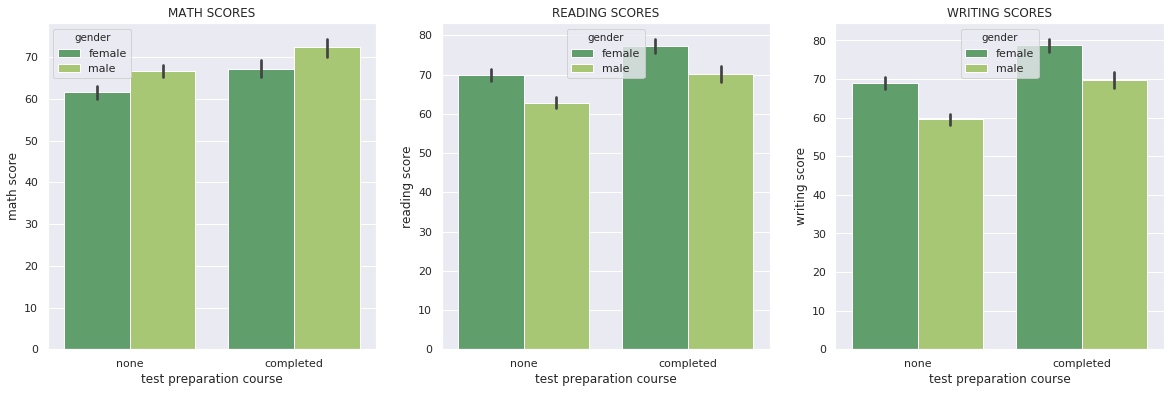

In [0]:
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
sns.barplot(x='test preparation course',y='math score',data=data,hue='gender',palette='summer')
plt.title('MATH SCORES')
plt.subplot(1, 3, 2)
sns.barplot(x='test preparation course',y='reading score',data=data,hue='gender',palette='summer')
plt.title('READING SCORES')
plt.subplot(1, 3, 3)
sns.barplot(x='test preparation course',y='writing score',data=data,hue='gender',palette='summer')
plt.title('WRITING SCORES')
plt.show()

Из графика выше мы можем сделать вывод, что по математике оценки у мужчин выше чем у женщин независимо от того, закончил человек подготовительный курс или нет. 
Из двух других графиков мы можем сделать вывод, что женщины в целом лучше сдают чтение и письмо. 
Из трех графиков можно сделать вывод, что если подготовительный курс был завершен, то человек получает оценки выше. 

Посмотрим как соотносятся данные по половому признаку

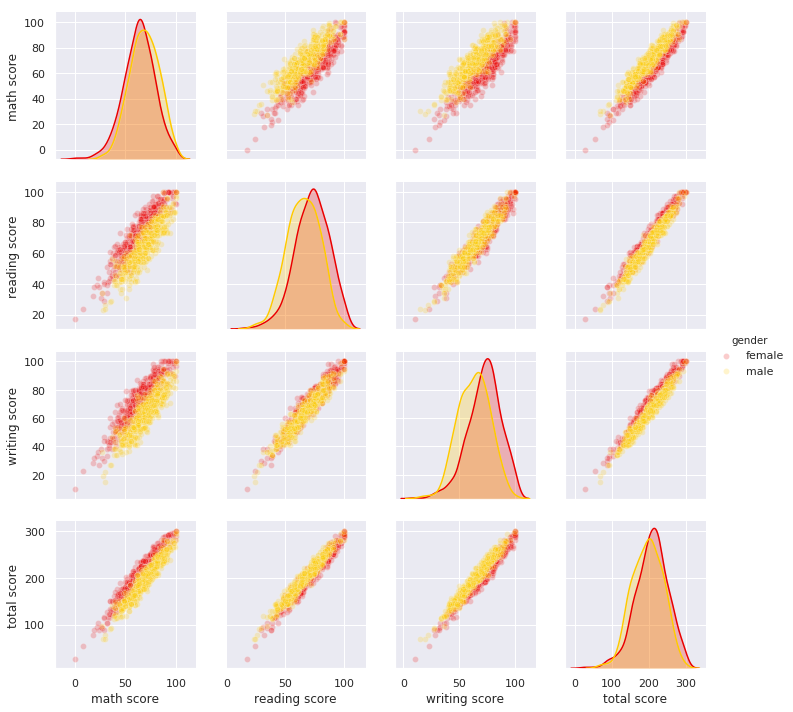

In [0]:
sns.pairplot(data=data,hue='gender',plot_kws={'alpha':0.2},palette='hot')
plt.show()

Из графиков видно, что данные сильно коррелированы, классы хорошо отделяются по математике - чтению, математике - письму. 

Посмотрим что из себя представляет столбик **lunch**

In [0]:
data['lunch'].unique()

array(['standard', 'free/reduced'], dtype=object)

Посмотрим, как обед влияет на баллы

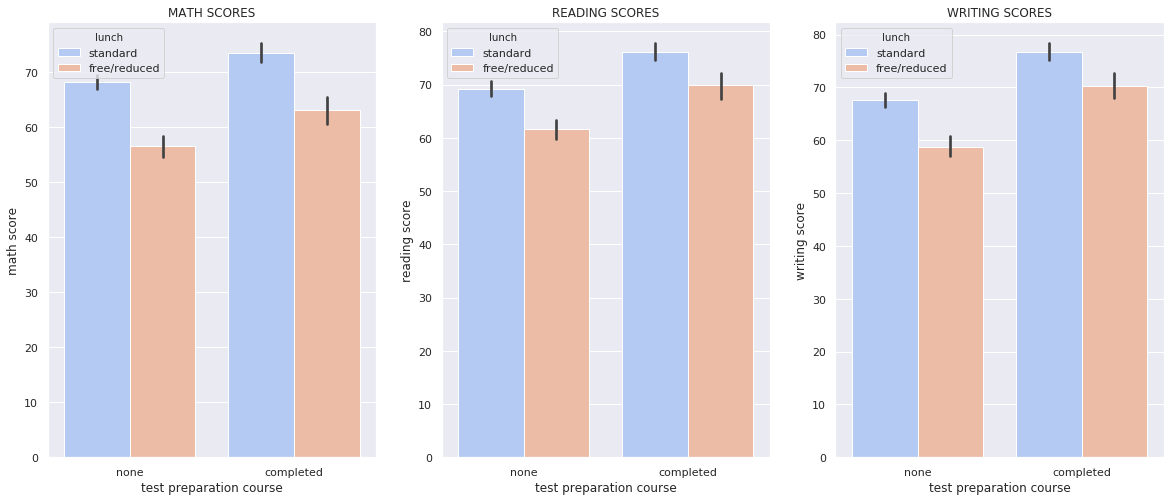

In [0]:
plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
sns.barplot(x='test preparation course',y='math score',data=data,hue='lunch',palette='coolwarm')
plt.title('MATH SCORES')
plt.subplot(1, 3, 2)
sns.barplot(x='test preparation course',y='reading score',data=data,hue='lunch',palette='coolwarm')
plt.title('READING SCORES')
plt.subplot(1, 3, 3)
sns.barplot(x='test preparation course',y='writing score',data=data,hue='lunch',palette='coolwarm')
plt.title('WRITING SCORES')
plt.show()

В общем и целом, в обоих классах людей, употребляющих стандартный ланч, больше. 

Посмотрим на людей, получивших максимальное количество баллов:

In [0]:
data[(data['math score'] > 90) & (data['reading score'] > 90) & (data['writing score']>90)]\
.sort_values(by=['total score'],ascending=False).head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score,pass_math
962,female,group E,associate's degree,standard,none,100,100,100,300,Pass
458,female,group E,bachelor's degree,standard,none,100,100,100,300,Pass
916,male,group E,bachelor's degree,standard,completed,100,100,100,300,Pass
114,female,group E,bachelor's degree,standard,completed,99,100,100,299,Pass
179,female,group D,some high school,standard,completed,97,100,100,297,Pass


Первый двое топовых студенты либо гении, либо приготовили шпаргалки, так как их подготовительные курсы не были завершены. 

Посмотрим распределение оценок по национальности. 

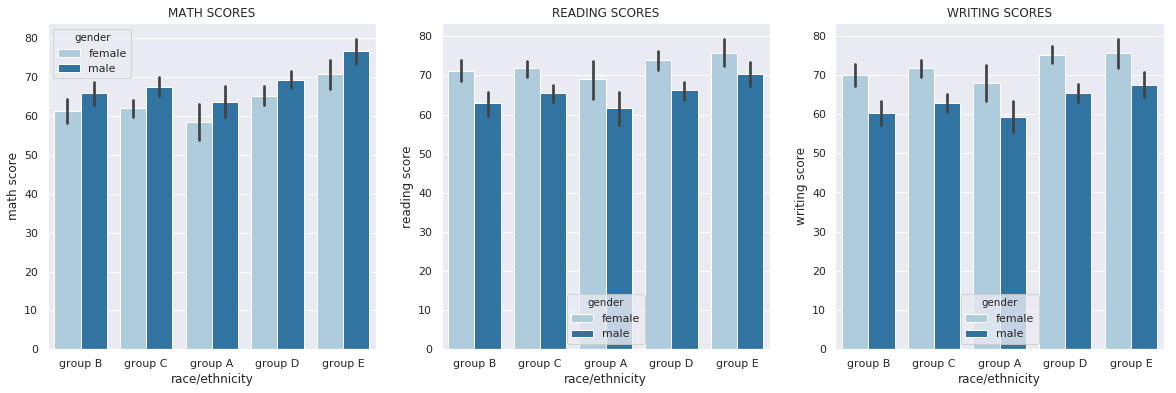

In [0]:
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
plt.title('MATH SCORES')
sns.barplot(x='race/ethnicity',y='math score',data=data,hue='gender',palette='Paired')
plt.subplot(1, 3, 2)
plt.title('READING SCORES')
sns.barplot(x='race/ethnicity',y='reading score',data=data,hue='gender',palette='Paired')
plt.subplot(1, 3, 3)
plt.title('WRITING SCORES')
sns.barplot(x='race/ethnicity',y='writing score',data=data,hue='gender',palette='Paired')
plt.show()

Группа Е имеет самые высокие показатели (больше всего людей в этой группе), причем больше сдавших по всем предметам. 

Посмотрим распределение образования родителей 

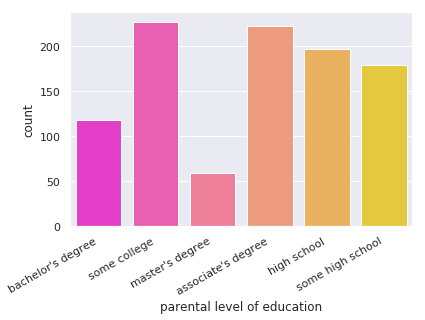

In [0]:
fig,ax=plt.subplots()
sns.countplot(x='parental level of education',data=data,palette='spring')
plt.tight_layout()
fig.autofmt_xdate()

Можно заметить, что в основном родители получили associate's degree или some college, очень мало имеют магистерское образование. 

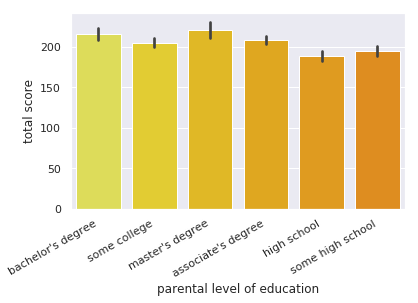

In [0]:
fig,ax=plt.subplots()
sns.barplot(x=data['parental level of education'],y='total score',data=data,palette='Wistia')
fig.autofmt_xdate()

 Можно заметить, что есть студенты, чьи родители получили степень магистра, имеют успеваемость выше, чем остальные. 

# **Линейная регрессия на основе датасета о студентах**

Построим модель линейной регрессии на основе данного датасета. Таргет значение - total score.

In [0]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score
0,female,group B,bachelor's degree,standard,none,72,72,74,218
1,female,group C,some college,standard,completed,69,90,88,247
2,female,group B,master's degree,standard,none,90,95,93,278
3,male,group A,associate's degree,free/reduced,none,47,57,44,148
4,male,group C,some college,standard,none,76,78,75,229


Добавим класс 'sex' на основе 'gender' значеий.

In [0]:
data['sex'] = data['gender']
data.loc[data['gender'] == 'female', 'sex'] = 0
data.loc[data['gender'] == 'male', 'sex'] = 1
data

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score,sex
0,female,group B,bachelor's degree,standard,none,72,72,74,218,0
1,female,group C,some college,standard,completed,69,90,88,247,0
2,female,group B,master's degree,standard,none,90,95,93,278,0
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,1
4,male,group C,some college,standard,none,76,78,75,229,1
5,female,group B,associate's degree,standard,none,71,83,78,232,0
6,female,group B,some college,standard,completed,88,95,92,275,0
7,male,group B,some college,free/reduced,none,40,43,39,122,1
8,male,group D,high school,free/reduced,completed,64,64,67,195,1
9,female,group B,high school,free/reduced,none,38,60,50,148,0


Добавим колонку 'race' на основе колонки 'race/ethnicity'

In [0]:
data['race'] = data['race/ethnicity']
data.loc[data['race/ethnicity'] == 'group A', 'race'] = 0
data.loc[data['race/ethnicity'] == 'group B', 'race'] = 1
data.loc[data['race/ethnicity'] == 'group C', 'race'] = 2
data.loc[data['race/ethnicity'] == 'group D', 'race'] = 3
data.loc[data['race/ethnicity'] == 'group E', 'race'] = 4
data

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score,sex,race
0,female,group B,bachelor's degree,standard,none,72,72,74,218,0,1
1,female,group C,some college,standard,completed,69,90,88,247,0,2
2,female,group B,master's degree,standard,none,90,95,93,278,0,1
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,1,0
4,male,group C,some college,standard,none,76,78,75,229,1,2
5,female,group B,associate's degree,standard,none,71,83,78,232,0,1
6,female,group B,some college,standard,completed,88,95,92,275,0,1
7,male,group B,some college,free/reduced,none,40,43,39,122,1,1
8,male,group D,high school,free/reduced,completed,64,64,67,195,1,3
9,female,group B,high school,free/reduced,none,38,60,50,148,0,1


Заменим колонку 'parental level of education' на 'parent'

In [0]:
data['parent'] = data['parental level of education']
data.loc[data['parental level of education'] == 'high school', 'parent'] = 0
data.loc[data['parental level of education'] == 'some high school', 'parent'] = 1
data.loc[data['parental level of education'] == 'some college', 'parent'] = 2
data.loc[data['parental level of education'] == 'bachelor\'s degree', 'parent'] = 3
data.loc[data['parental level of education'] == 'master\'s degree', 'parent'] = 4
data.loc[data['parental level of education'] == 'associate\'s degree', 'parent'] = 5
data

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score,sex,race,parent
0,female,group B,bachelor's degree,standard,none,72,72,74,218,0,1,3
1,female,group C,some college,standard,completed,69,90,88,247,0,2,2
2,female,group B,master's degree,standard,none,90,95,93,278,0,1,4
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,1,0,5
4,male,group C,some college,standard,none,76,78,75,229,1,2,2
5,female,group B,associate's degree,standard,none,71,83,78,232,0,1,5
6,female,group B,some college,standard,completed,88,95,92,275,0,1,2
7,male,group B,some college,free/reduced,none,40,43,39,122,1,1,2
8,male,group D,high school,free/reduced,completed,64,64,67,195,1,3,0
9,female,group B,high school,free/reduced,none,38,60,50,148,0,1,0


Заменим колонку 'lunch' на 'lunch_type'

In [0]:
data['lunch_type'] = data['lunch']
data.loc[data['lunch'] == 'free/reduced', 'lunch_type'] = 0
data.loc[data['lunch'] == 'standard', 'lunch_type'] = 1
data[:2]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score,sex,race,parent,test,lunch_type
0,female,group B,bachelor's degree,standard,none,72,72,74,218,0,1,3,0,1
1,female,group C,some college,standard,completed,69,90,88,247,0,2,2,1,1


Заменим колонку "test preparation course" на "test"

In [0]:
data['test'] = data['test preparation course']
data.loc[data['test preparation course'] == 'none', 'test'] = 0
data.loc[data['test preparation course'] == 'completed', 'test'] = 1
data[:3]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,total score,sex,race,parent,test
0,female,group B,bachelor's degree,standard,none,72,72,74,218,0,1,3,0
1,female,group C,some college,standard,completed,69,90,88,247,0,2,2,1
2,female,group B,master's degree,standard,none,90,95,93,278,0,1,4,0


Создадим таблицу X - это вектор тренировочных данных

In [0]:
X = data[['sex',	'race',	'parent',	'lunch_type',	'test']]
X

,sex,race,parent,lunch_type,test
0,0,1,3,1,0
1,0,2,2,1,1
2,0,1,4,1,0
3,1,0,5,0,0
4,1,2,2,1,0
5,0,1,5,1,0
6,0,1,2,1,1
7,1,1,2,0,0
8,1,3,0,0,1
9,0,1,0,0,0


Y - значение таргет

In [0]:
Y = data['total score']

Разделим данные на **тренировочные** и **тестовые** данные (80% тренировочных и 20% тестовых):

In [0]:
from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2, random_state = 0)

print("Number train dataset: ", len(X_train))
print("Number test dataset: ", len(X_test))
print("Total number: ", len(X_train)+len(X_test))

Number train dataset:  800
Number test dataset:  200
Total number:  1000


Построим линейную регрессию

In [0]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Посмотрим **качество модели** на тестовых данных

In [0]:
Y_pred = model.predict(X_test)

Сравним 4 первых элемента Y предсказанное значение и Y истинное

In [0]:
Y_pred[:4]

array([191.09732936, 180.62917599, 184.99624698, 174.31517493])

In [0]:
np.array(y_test)[:4]

array([208, 232, 136, 203])

Посчитаем качество как **сумму абсолютных отклонений от истинных значений**

In [0]:
abs_error = abs(Y_pred - np.array(y_test))

In [0]:
abs_error[:4]

array([16.90267064, 51.37082401, 48.99624698, 28.68482507])

In [0]:
print('сумма абсолютных отклонений равна: ', (sum(abs_error))/len(abs_error))

сумма абсолютных отклонений равна:  31.184056920910624


In [0]:
print('min:', min(Y))
print('max:', max(Y))

min: 5
max: 300


Посчитаем **квадратичную ошибку**

In [0]:
(sum((Y_pred - np.array(y_test))**2)/len(Y_pred))**0.5

38.536122638462714

In [0]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(Y_pred, np.array(y_test))**0.5)

38.53612263846271


# Логистическая регрессия

Загрузим датасет ирисов. 

In [0]:
sns.set(style="ticks", color_codes=True)
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Мы хотим предсказать к какому классу относится цветок по 4 параметрам. Всего 3 класса. С какой-то вероятностью новый цветок, которого нет в датасете, будет относится к одному из 4ых цветков.

In [0]:
iris['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [0]:
print(len((iris[iris['species']=='setosa'])))
print(len(iris[iris['species']=='versicolor']))
print(len(iris[iris['species']=='virginica']))

50
50
50


In [0]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
X, y = load_iris(return_X_y=True)
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X, y)
clf.predict(X[:2, :])

clf.predict_proba(X[:2, :]) 


clf.score(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.9733333333333334

# Датасет №2. 

Датасет топовых песен 2018 с сервера spotify. 

https://www.kaggle.com/nadintamer/top-spotify-tracks-of-2018

In [0]:
url='http://yustiks.ru/top2018.csv'
s=requests.get(url).content
data=pd.read_csv(io.StringIO(s.decode('utf-8')))
data.head()

,id,name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,6DCZcSspjsKoFjzjrWoCd,God's Plan,Drake,0.754,0.449,7.0,-9.211,1.0,0.1090,0.0332,0.000083,0.552,0.357,77.169,198973.0,4.0
1,3ee8Jmje8o58CHK66QrVC,SAD!,XXXTENTACION,0.740,0.613,8.0,-4.880,1.0,0.1450,0.2580,0.003720,0.123,0.473,75.023,166606.0,4.0
2,0e7ipj03S05BNilyu5bRz,rockstar (feat. 21 Savage),Post Malone,0.587,0.535,5.0,-6.090,0.0,0.0898,0.1170,0.000066,0.131,0.140,159.847,218147.0,4.0
3,3swc6WTsr7rl9DqQKQA55,Psycho (feat. Ty Dolla $ign),Post Malone,0.739,0.559,8.0,-8.011,1.0,0.1170,0.5800,0.000000,0.112,0.439,140.124,221440.0,4.0
4,2G7V7zsVDxg1yRsu7Ew9R,In My Feelings,Drake,0.835,0.626,1.0,-5.833,1.0,0.1250,0.0589,0.000060,0.396,0.350,91.030,217925.0,4.0


Из данных мы имеем:
* **idSpotify** - id песни
* **name** - название песни
* **artists** - исполнитель
* **danceability** - означает насколько подходит музыка для танцев (основано на анализетаких музыкальных элементов как tempo, rhythm stability, beat strength, и overall regularity ) 0 означает что трек не подходит для танцев, 1 - что очень подходит.
* **energy** - значение от 0 до 1. Насколько интенсивная по энергетике. Например, death metal будет иметь 1 в качестве значения, музыка Баха - 0. Для анализа этой переменной используются такие данные, как dynamic range, perceived loudness, timbre, onset rate, и general entropy.
* **key** - ключ, означает высотный класс. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.
* **loudness** - насколько громкая (децибелы). Гомкость усреднена по всему треку. Значения от  -60 до 0 db.
* **mode** -  показывает наклонение трека (мажор или минор), наклоне́ние в теории музыки — отличительные свойства терцового аккорда, звукоряда, тонального лада, которыми обусловливается их принадлежность к мажору или минору. Мажор представлен 1, минор 0.
* **speechiness** - обнаруживает, есть ли слова в песне. Чем больше слов в песне, чем больше значение к 1. Значение больше 0.66 означает, что трек полностью состоит из слов. Значения между 0.33 и 0.66 означает, что скорее всего трек содержит музыку + речь (рэп, например). Значение меньше 0.33 означает просто музыку. 
* **acousticness** - значение между 0 и 1. 1 - показывает насколько музыка акустична. 
* **instrumentalness** - показывает сколько в музыке вокала. "Ooh" и "aah" звуки считаются вокалом. Рэп или чтение стихов тоже вокал. Чем ближе значение к 1, тем больше вероятность, что трек не содержит вокала.  Значение больше 0.5 показывает инструментальный трек, но вероятность выше если значение приближается к 1.
* **liveness** - показывает присутствие аудитории в музыке (живое исполнение трека). Чем выше значение, тем больше вероятность, что трек исполнен вживую. Значение больше 0.8 показывает высокую вероятность живого исполнения. 
* **valence** - значение от 0 до 1 показывает позитивность трека. Треки с высоким значением valence означают позитивную музыку (счастливая, бодрящая), музыка с низким значением показывает грустную эмоциональность мелодии (злость, негатив). 
* **tempo** - темп музыки (скорость исполнения музыки) - бит в минуту (BPM). 
* **duration_ms** - сколько длится музыка в миллисекундах. 
* **time_signature** - тактовый размер в музыке — количественная характеристика тактового метра, указывающая число долей в такте


Посмотрим стандартные статистические параметры

In [0]:
 data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00
mean,0.71646,0.659060,5.330000,-5.677640,0.590000,0.115569,0.195701,0.001584,0.158302,0.484443,119.904180,205206.780000,3.98
std,0.13107,0.145067,3.676447,1.777577,0.494311,0.104527,0.220946,0.013449,0.111662,0.206145,28.795984,40007.893404,0.20
min,0.25800,0.296000,0.000000,-10.109000,0.000000,0.023200,0.000282,0.000000,0.021500,0.079600,64.934000,95467.000000,3.00
25%,0.63550,0.562000,1.750000,-6.650500,0.000000,0.045350,0.040225,0.000000,0.094675,0.341000,95.730750,184680.000000,4.00
50%,0.73300,0.678000,5.000000,-5.566500,1.000000,0.074950,0.109000,0.000000,0.118500,0.470500,120.116000,205047.500000,4.00
75%,0.79825,0.772250,8.250000,-4.363750,1.000000,0.137000,0.247750,0.000031,0.170750,0.641500,140.022750,221493.250000,4.00
max,0.96400,0.909000,11.000000,-2.384000,1.000000,0.530000,0.934000,0.134000,0.636000,0.931000,198.075000,417920.000000,5.00


Всего 100 песен. 

Посмотрим есть ли выбросы

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
id                  100 non-null object
name                100 non-null object
artists             100 non-null object
danceability        100 non-null float64
energy              100 non-null float64
key                 100 non-null float64
loudness            100 non-null float64
mode                100 non-null float64
speechiness         100 non-null float64
acousticness        100 non-null float64
instrumentalness    100 non-null float64
liveness            100 non-null float64
valence             100 non-null float64
tempo               100 non-null float64
duration_ms         100 non-null float64
time_signature      100 non-null float64
dtypes: float64(13), object(3)
memory usage: 12.6+ KB


Создадим колонку, где миллисекунды представим ввиде минут

In [0]:
data['Duration_min']=data['duration_ms']/60000

Посмотрим графики распределения величин

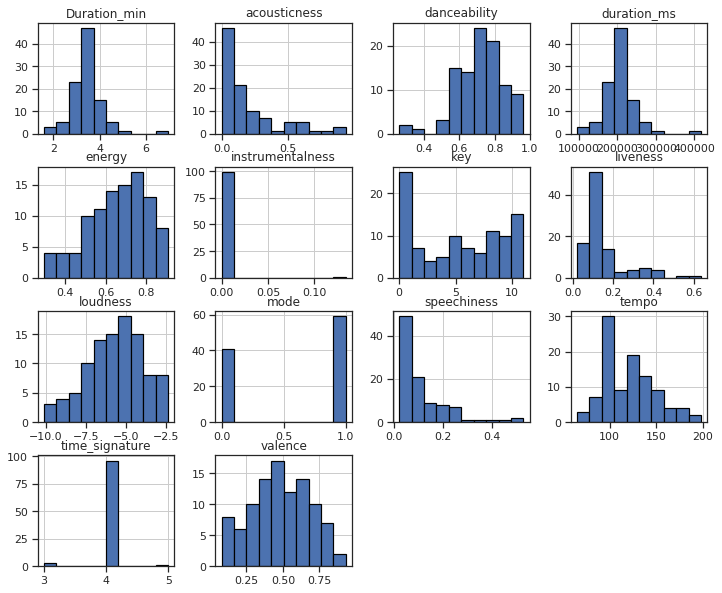

In [0]:
data.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(12,10)
plt.show()

Можно заметить, что Duration_min имеет точно такой же график, как и duration_ms. Так как легче хранить переменные меньшего размера, удалим колонку duration_ms. 

In [0]:
data.drop(columns='duration_ms',inplace=True)

Построим матрицу корелляций

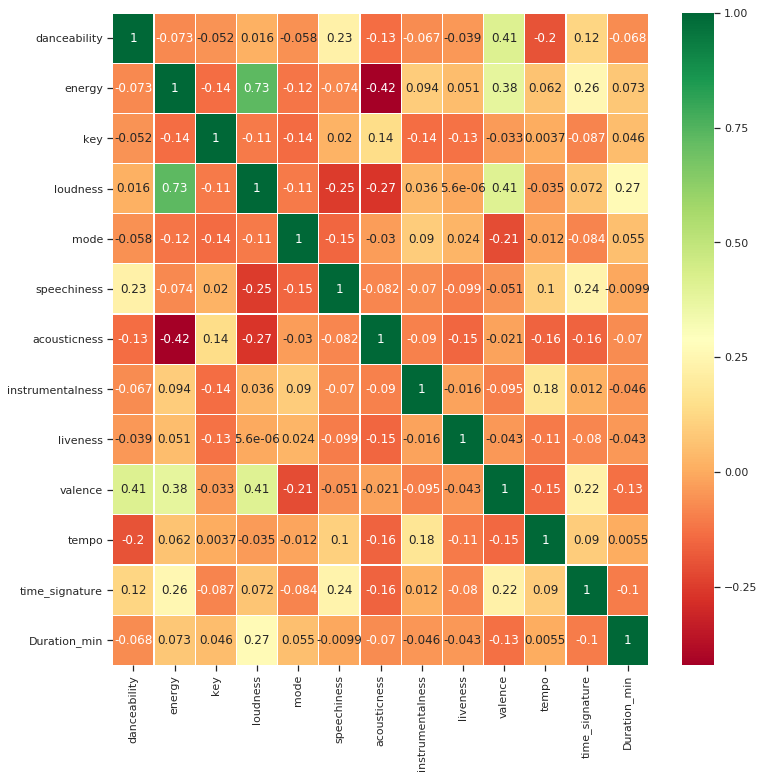

In [0]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [0]:
matr = data.corr().round(2)
matr = np.array(matr)
matr = sorted(matr.reshape(matr.shape[0]**2))
matr[0:5]

[-0.42, -0.42, -0.27, -0.27, -0.25]

Минимальные значения корреляции = -0.42 и -0.26

In [0]:
matr[-16:-1]

[0.41, 0.73, 0.73, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Максимальные значения корреляции 0.73 и 0.41 (1 - это диагональные элементы)

Можно заметить высокую корелляцию между такими данными как **loudness** и **energy**, максимальная отрицательная корреляция **acousticness** и **energy**. 

**Посмотрим Top-10 исполнителей**

In [0]:
data['artists'].value_counts().head(10) # value_counts() - для каждого значения вычисляет сколько раз оно встречается. 

XXXTENTACION      6
Post Malone       6
Drake             4
Marshmello        3
Ed Sheeran        3
Camila Cabello    2
Maroon 5          2
Kendrick Lamar    2
Selena Gomez      2
Ariana Grande     2
Name: artists, dtype: int64

Проведем анализ переменной Dancebility: построим плотность распределения

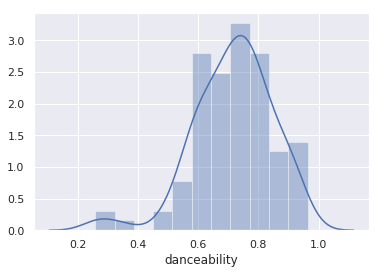

In [0]:
sns.set_style(style='darkgrid')
sns.distplot(data['danceability'],hist=True,kde=True)
plt.show()

Можно заметить, что распределение имеет нормальный вид, но чтобы сделать более детальный анализ, разделим данные на 3 класса:

*   больше чем 75% - очень танцевальный трек
*   между 50% и 74% - средне-танцевальный трек
*   меньше 50% - нетанцевальный трек


In [0]:
# создадим условия 
Vd=data['danceability']>=0.75
Ld=(data['danceability']>=0.5) & (data['danceability']<0.75)
Nd=data['danceability']<0.5
#создадим новую талицу Dance, где колонка Percent будет означать процент данных попавших в данную категорию
Dance=pd.DataFrame([Vd.sum(),Ld.sum(),Nd.sum()], columns=['percent'],
                   index=['Very_dance','Regular','Instrumental'])

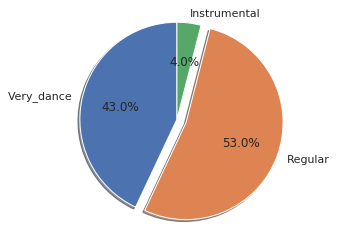

In [0]:
labels = 'Very_dance','Regular','Instrumental'
sizes = list(Dance['percent'])
explode = (0, 0.1, 0 )  #выделим вторую колонку, как максимальную

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # equal чтобы нарисовать график ввиде круга

plt.show()

То же самое проделаем с Energy значением:

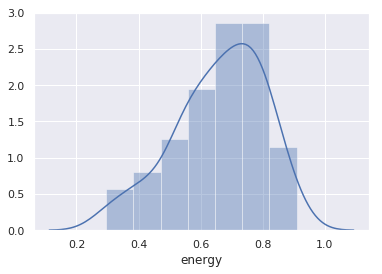

In [0]:
sns.distplot(data['energy'])
plt.show()

Разделим на 3 класса:


*   очень энергичная (>0.75)
*   среднеэнергичная (от 0.5 до 0.75)
*   малоэнергичная (менее 0.5)



In [0]:
# зададим условия
Ve=data['energy']>=0.75
Re=(data['energy']>=0.5) & (data['energy']<0.75)
Le=data['energy']<0.5

Создадим новую таблицу с рядами 'Very Energy','Regular Energy','Low Energy' и колонками процент данных в каждом классе

In [0]:
Energy=pd.DataFrame([Ve.sum(),Re.sum(),Le.sum()],columns=['percent'],
                   index=['Very Energy','Regular Energy','Low Energy'])

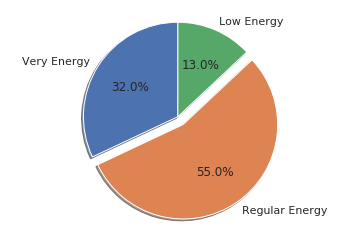

In [0]:
labels = 'Very Energy','Regular Energy','Low Energy'
sizes = list(Energy['percent'])
explode = (0, 0.1, 0 )  #выделим вторую колонку, как максимальную

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # equal чтобы нарисовать график ввиде круга

plt.show()

Добавим детальную корелляцию данных (по предыдущему анализу возьмем 'danceability','energy','valence','loudness','tempo')

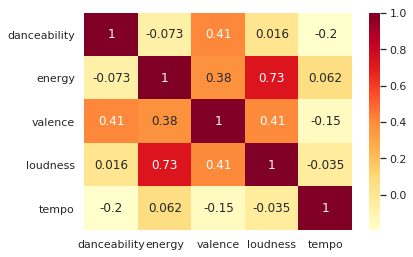

In [0]:
Correlation=data[['danceability','energy','valence','loudness','tempo']]
sns.heatmap(Correlation.corr(),annot=True,cmap="YlOrRd")
plt.show()

Данная матрица более детально показывает корреляцию между данными величинами.

Посмотрим более детальную корелляцию energy и loudness.

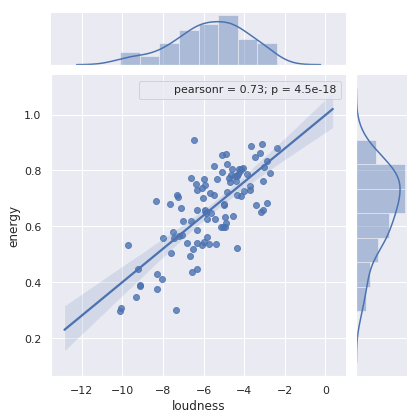

In [0]:
import warnings
warnings.filterwarnings("ignore")
sns.jointplot(data=Correlation,y='energy',x='loudness',kind='reg',stat_func=pearsonr)
plt.show()

Выводы: можно увидеть, что чем ближе значение громкости к 0, тем более вероятно, что трек будет иметь высокий ритм. 

Посмотрим что мы можем сделать с темпом музыки. 

Выберем 5 основных класса по скоростям музыки:

* Length: очень медленная (20 bpm)
* Adagio:медленная и спокойная (66 to 76 bpm)
* Andante: умеренный темп (в характере шага) (76 to 108 bpm)
* Allegro: скорее чем andante. (110 to 168 bpm).
* Presto: очень быстро (168 to 200 bpm).

In [0]:
# создадим новую колонку Rhythm
data['Rhythm']=data['tempo']
# цикл чтобы изменить новую колонку в соответствии с классом
for i in range(99):
    if data['tempo'][i]>168:
        data['Rhythm'][i]='Presto'
    if (data['tempo'][i]>=110) & (data['tempo'][i]<=168):
        data['Rhythm'][i]='Allegro'
    elif (data['tempo'][i]>=76) & (data['tempo'][i]<=108):
        data['Rhythm'][i]='Andante'
    elif (data['tempo'][i]>=66) & (data['tempo'][i]<=76):
        data['Rhythm'][i]='Adagio'
    elif data['tempo'][i]<65:
        data['Rhythm'][i]='Length' 

Проверим, правильно ли все получилось

In [0]:
data[['tempo','Rhythm']].head()

,tempo,Rhythm
0,77.169,Andante
1,75.023,Adagio
2,159.847,Allegro
3,140.124,Allegro
4,91.030,Andante


Посмотрим распределение значений по скоростям звучания

In [0]:
data['Rhythm'].value_counts()

Allegro    46
Andante    44
Presto      7
126.684     1
Adagio      1
Length      1
Name: Rhythm, dtype: int64

Можно увидеть, что в топе-100 песен 2018 года мало спокойной музыки (2), много быстрой (но не метал) - 46, умеренно быстрой - 44. 

Посмотрим **ТОП-10 танцевальных песен**

In [0]:
data[['name','artists','danceability','valence','tempo','Rhythm']].sort_values(by='danceability',ascending=False).head(10)

,name,artists,danceability,valence,tempo,Rhythm
91,Yes Indeed,Lil Baby,0.964,0.562,119.958,Allegro
55,FEFE (feat. Nicki Minaj & Murda Beatz),6ix9ine,0.931,0.376,125.978,Allegro
19,Look Alive (feat. Drake),BlocBoy JB,0.922,0.595,140.022,Allegro
18,Moonlight,XXXTENTACION,0.921,0.711,128.009,Allegro
61,Nonstop,Drake,0.912,0.422,154.983,Allegro
89,Bella,Wolfine,0.909,0.844,94.016,Andante
73,Walk It Talk It,Migos,0.909,0.406,145.905,Allegro
82,HUMBLE.,Kendrick Lamar,0.908,0.421,150.011,Allegro
21,Te Bot? - Remix,Nio Garcia,0.903,0.442,96.507,Andante
30,Taste (feat. Offset),Tyga,0.884,0.342,97.994,Andante


Посмотрим **ТОП-10** самых энергичных песен

In [0]:
data[['name','artists','energy','valence','tempo','Rhythm']].sort_values(by='energy',ascending=False).head(10)

,name,artists,energy,valence,tempo,Rhythm
12,Nice For What,Drake,0.909,0.757,93.394,Andante
77,"1, 2, 3 (feat. Jason Derulo & De La Ghetto)",Sofia Reyes,0.895,0.794,94.968,Andante
34,?chame La Culpa,Luis Fonsi,0.889,0.649,96.024,Andante
9,FRIENDS,Marshmello,0.880,0.534,95.079,Andante
7,One Kiss (with Dua Lipa),Calvin Harris,0.862,0.592,123.994,Allegro
46,Finesse (Remix) [feat. Cardi B],Bruno Mars,0.859,0.926,105.115,Andante
23,Youngblood,5 Seconds of Summer,0.854,0.152,120.274,Allegro
41,Dura,Daddy Yankee,0.848,0.828,95.000,Andante
45,Jackie Chan,Ti?sto,0.834,0.687,128.005,Allegro
43,Thunder,Imagine Dragons,0.822,0.288,167.997,Allegro


**ТОП-10 песен, создающих позитивное настроение**

In [0]:
data[['name','artists','energy','valence','tempo','Rhythm']].sort_values(by='valence',ascending=False).head(10)

,name,artists,energy,valence,tempo,Rhythm
25,Shape of You,Ed Sheeran,0.652,0.931,95.977,Andante
46,Finesse (Remix) [feat. Cardi B],Bruno Mars,0.859,0.926,105.115,Andante
89,Bella,Wolfine,0.493,0.844,94.016,Andante
66,D?jala que vuelva (feat. Manuel Turizo),Piso 21,0.788,0.839,170.019,Presto
78,Criminal,Natti Natasha,0.813,0.839,79.997,Andante
41,Dura,Daddy Yankee,0.848,0.828,95.000,Andante
59,Sin Pijama,Becky G,0.745,0.820,94.014,Andante
77,"1, 2, 3 (feat. Jason Derulo & De La Ghetto)",Sofia Reyes,0.895,0.794,94.968,Andante
44,Me Niego,Reik,0.779,0.768,94.023,Andante
12,Nice For What,Drake,0.909,0.757,93.394,Andante


Проанализируем 4 самых популярных исполнителя, чтобы сделать выводы о вкусах населения

In [0]:
data['artists'].value_counts().head(4)

XXXTENTACION    6
Post Malone     6
Drake           4
Marshmello      3
Name: artists, dtype: int64

In [0]:
# возьмем исполнителя XXXTENTACION
XXXTENT=data[data['artists']=='XXXTENTACION']
# выведем на экран все его песни
XXXTENT[['name','danceability','energy','loudness','valence','tempo','Rhythm']]

,name,danceability,energy,loudness,valence,tempo,Rhythm
1,SAD!,0.740,0.613,-4.880,0.473,75.023,Adagio
18,Moonlight,0.921,0.537,-5.723,0.711,128.009,Allegro
28,Jocelyn Flores,0.872,0.391,-9.144,0.437,134.021,Allegro
38,changes,0.669,0.308,-10.068,0.520,64.934,Length
62,Fuck Love (feat. Trippie Redd),0.797,0.533,-9.740,0.329,131.036,Allegro
94,Everybody Dies In Their Nightmares,0.734,0.570,-7.066,0.689,129.953,Allegro


Можно заметить, что песнях XXXTENTACION  много ритма Allegro, поэтому высокий уровень танцевальности, скорее всего, исполнитель записывает  хип-хоп. Действительно, если проверить, XXXTENTACION - американский рэпер. 

Посмотрим исполнителя Post Malone

In [0]:
PMalone=data[data['artists']=='Post Malone']
PMalone[['name','danceability','energy','loudness','valence','tempo','Rhythm']]


,name,danceability,energy,loudness,valence,tempo,Rhythm
2,rockstar (feat. 21 Savage),0.587,0.535,-6.090,0.140,159.847,Allegro
3,Psycho (feat. Ty Dolla $ign),0.739,0.559,-8.011,0.439,140.124,Allegro
5,Better Now,0.680,0.563,-5.843,0.374,145.028,Allegro
32,I Fall Apart,0.556,0.538,-5.408,0.291,143.950,Allegro
75,Candy Paint,0.670,0.654,-5.944,0.438,180.024,Presto
76,Congratulations,0.630,0.804,-4.183,0.492,123.146,Allegro


Можно сделать вывод, что Post Malone также записывает быструю музыку Allegro, но танцевальных его/ее песен ниже, чем у XXXTENTACION. Смотрим  в википедию, и оказывается, данный исполнитель тоже рэпер. 

Проанализируем песни исполнителя **Drake**

In [0]:
Drake=data[data['artists']=='Drake']
Drake[['name','danceability','energy','loudness','valence','tempo','Rhythm']]

,name,danceability,energy,loudness,valence,tempo,Rhythm
0,God's Plan,0.754,0.449,-9.211,0.357,77.169,Andante
4,In My Feelings,0.835,0.626,-5.833,0.350,91.030,Andante
12,Nice For What,0.586,0.909,-6.474,0.757,93.394,Andante
61,Nonstop,0.912,0.412,-8.074,0.422,154.983,Allegro


Проанализируем песни исполнителя **Ed Sheeran**

In [0]:
Edshe=data[data['artists']=='Ed Sheeran']
Edshe[['name','danceability','energy','loudness','valence','acousticness','tempo','Rhythm']]

,name,danceability,energy,loudness,valence,acousticness,tempo,Rhythm
25,Shape of You,0.825,0.652,-3.183,0.931,0.581,95.977,Andante
29,Perfect,0.599,0.448,-6.312,0.168,0.163,95.050,Andante
84,Perfect Duet (Ed Sheeran & Beyonc?),0.587,0.299,-7.365,0.356,0.779,94.992,Andante


У Ed Sheeran песни очень медленные. 

**Обработка колонки Mode**

In [0]:
#создаем новые таблицы с разбивкой на minor и major
Mayores=data[data['mode']==1]
Menores=data[data['mode']==0]
# разделенеие по танцевальности
MayoresD=Mayores[Mayores['danceability']>=0.5]
MenoresD=Menores[Menores['danceability']>=0.5]
# удаляем колонки mode и time_signature
MayoresD=Mayores.drop(columns=['mode','time_signature'])
MenoresD=Menores.drop(columns=['mode','time_signature'])

Корелляция или тепловая карта для major

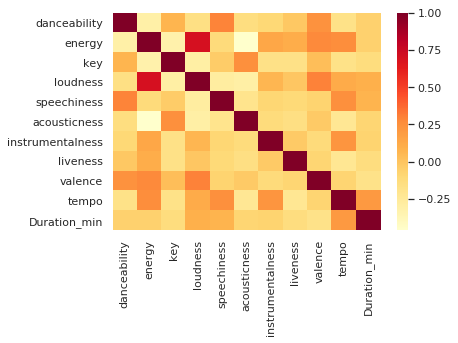

In [0]:
sns.heatmap(MayoresD.corr(),cmap="YlOrRd")
plt.show()

Тепловая карта для minor

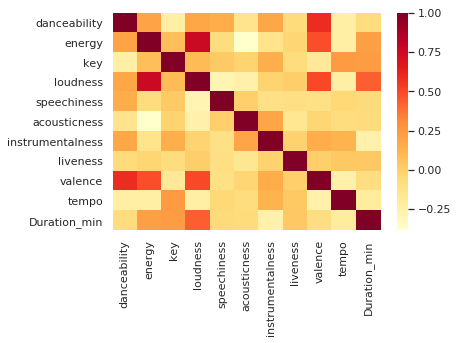

In [0]:
sns.heatmap(MenoresD.corr(),cmap="YlOrRd")
plt.show()

Посмотрим корелляцию более детально (для определенных значений)

In [0]:
MaycorD=MayoresD[['danceability','energy','valence','loudness','tempo']]
MencorD=MenoresD[['danceability','energy','valence','loudness','tempo']]

Mayor:

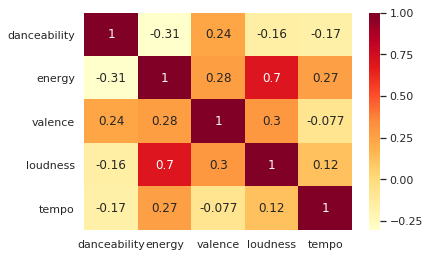

In [0]:
sns.heatmap(MaycorD.corr(),annot=True,cmap="YlOrRd")
plt.show()

Minor

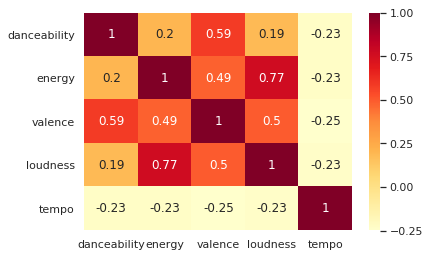

In [0]:
sns.heatmap(MencorD.corr(),annot=True,cmap="YlOrRd")
plt.show()

Как видим, увеличение масштаба дает нам лучшую корелляцию 

**Обработка колонки Keys**

Изменим высотные классы от номеров к названиям

In [0]:
for i in range(100):
    if data['key'][i]==0 : data['key'][i]='C'
    elif data['key'][i]==1 : data['key'][i]='C#'
    elif data['key'][i]==2 : data['key'][i]='D'
    elif data['key'][i]==3 : data['key'][i]='D#'
    elif data['key'][i]==4 : data['key'][i]='E'
    elif data['key'][i]==5 : data['key'][i]='F'    
    elif data['key'][i]==6 : data['key'][i]='F#'
    elif data['key'][i]==7 : data['key'][i]='G'
    elif data['key'][i]==8 : data['key'][i]='G#'
    elif data['key'][i]==9 : data['key'][i]='A'
    elif data['key'][i]==10 : data['key'][i]='A#'
    elif data['key'][i]==11 : data['key'][i]='B'

Посмотрим самые используемые высотные классы

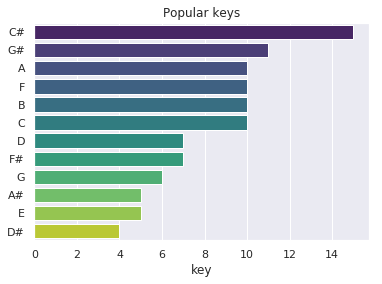

In [0]:
sns.set_style(style='darkgrid')
keys=data['key'].value_counts()
key_DF=pd.DataFrame(keys)
sns.barplot(x=key_DF.key, y=key_DF.index, palette="viridis")
plt.title('Popular keys')
plt.show()

Посмотрим самые танцевальные треки по высотным значениям

In [0]:
data[['danceability','energy','valence','key']].groupby(by='key').mean().sort_values(by='danceability',ascending=False)

,danceability,energy,valence
key,,,
G,0.764167,0.581000,0.427833
C#,0.762000,0.695800,0.570533
A,0.760300,0.680000,0.563600
A#,0.740800,0.663000,0.501600
C,0.735400,0.679600,0.469300
D#,0.721500,0.669000,0.485150
F,0.716400,0.631200,0.527800
B,0.702000,0.623100,0.423670
D,0.701571,0.698857,0.373714


Можно увидеть что самые танцевальные треки имеют значение G и C#. 

In [0]:
data[['danceability','energy','valence','key']].groupby(by='key').mean().sort_values(by='energy',ascending=False)

,danceability,energy,valence
key,,,
F#,0.636857,0.713857,0.370429
D,0.701571,0.698857,0.373714
C#,0.762000,0.695800,0.570533
A,0.760300,0.680000,0.563600
C,0.735400,0.679600,0.469300
D#,0.721500,0.669000,0.485150
A#,0.740800,0.663000,0.501600
E,0.605200,0.635800,0.436000
F,0.716400,0.631200,0.527800


По энергичности лидируют такие значения, как F#, D, C#.

Выводы:
По исходной базе данных можно сделать вывод, что есть сильная корелляция между значением energy и noise, с другой стороны, можно заметить, что основная причина, почему люди полюбили эти песни, связана со скоростью исполнения (основные tempo "allegro" и "andante", которые являются характеристиками жанров хип-хопа, регги, поп и рэп ).
